# Setup

In [2]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

2022-08-25 02:16:05.879144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 02:16:05.879175: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-25 02:16:21.863530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-25 02:16:21.863784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 02:16:21.863970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcub

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-08-25 02:16:21.864693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-25 02:16:21.864856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2022-08-25 02:16:21.865008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-25 02:16:21.865014: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are inst

# Online format pipeline (DDA fragmented masses)

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
from matplotlib import pyplot as plt
from proteolizarddata.data import PyTimsDataHandleDDA

dp = "../../datasets/CSSPred/M210115_001_Slot1-1_1_850.d"

cursor = PyTimsDataHandleDDA(dp)


2022-08-12 18:44:22.654353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 18:44:22.654378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BATCH_SIZE = 1
MAX_N = 1024
ATT_SIZE = 1
POINT_DIM = 3
NUM_SCORES = 6

#del model
from deepapex import model

isodet = model.get_model(MAX_N, ATT_SIZE, POINT_DIM, NUM_SCORES)

#isodet.reset_states()
#isodetect.save("model/model_checkpoint", save_format="tf", custom_objects=custom)

2022-08-12 18:44:40.374676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-12 18:44:40.374966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 18:44:40.375181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-12 18:44:40.375386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-12 18:44:40.375597: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [17]:
from scipy.sparse import dok_matrix, csr_matrix, csr_array
from sklearn.metrics.pairwise import cosine_similarity
from proteolizardalgo.isotopes import generate_pattern
from proteolizardalgo.hashing import TimsHasher
from proteolizarddata.data import MzSpectrum

pd.options.mode.chained_assignment = None#default='warn'

hasher = TimsHasher(trials=32, len_trial=32, seed=42, num_dalton=10, resolution=1)

NUM_PEAKS = 8
BUFFER = 0.1
STEP_SIZE = 1e-5

SIMIL_THOLD = 0.5
NUM_MZ_BINS = int(2e6)
SCAN_RANGE = 15

MZs = np.linspace(0.0, 1700.0, 20 + 1)
MZ_epsilon = (MZs[1] - MZs[0]) / 2

selected = cursor.get_selected_precursors()

INT_MIN = 100
INT_MAX = selected.Intensity.max()

for fid in cursor.precursor_frames:
    feature = selected[selected.Parent == fid].reset_index(drop=True)
    spec = feature.apply(lambda prec: generate_pattern(prec.MonoisotopicMz - BUFFER,
                                                       prec.MonoisotopicMz + NUM_PEAKS/prec.Charge + BUFFER,
                                                       STEP_SIZE,
                                                       prec.MonoisotopicMz*prec.Charge,
                                                       prec.Charge,
                                                       prec.Intensity,
                                                       NUM_PEAKS),
                         axis=1).values

    frame = cursor.get_frame(fid)
    try:
        hashed_frame = hasher.filter_frame_auto_correlation(frame)
    except IndexError:
        print("EMPTY FRAME")
        continue
        
    points = hashed_frame.data()[["mz", "scan", "intensity"]]
    points_filt = points[points.intensity >= INT_MIN].reset_index(drop=True)
    labels = np.zeros((len(points_filt), NUM_SCORES))
    
    for idx, row in feature.iterrows():

        lower_mz = row.MonoisotopicMz - BUFFER
        upper_mz = row.MonoisotopicMz + NUM_PEAKS/row.Charge + BUFFER

        hashed_slice = hashed_frame.filter_ranged(scan_min=int(row.ScanNumber) - SCAN_RANGE,
                                                  scan_max=int(row.ScanNumber) + SCAN_RANGE,
                                                  mz_min=lower_mz,
                                                  mz_max=upper_mz)


        hashed_specs = hashed_slice.get_spectra()
        vals = np.concatenate([sp.vectorize(3).values()  for sp in hashed_specs])
        rows = np.concatenate([[i]*len(sp.mz())          for i, sp in enumerate(hashed_specs)])
        idxs = np.concatenate([sp.vectorize(3).indices() for sp in hashed_specs])
        
        if idxs[0] < 0:
            continue

        data_specs = csr_array((vals, (rows, idxs)), shape=(rows[-1]+1, NUM_MZ_BINS))

        fsp = MzSpectrum(None, -1, -1, spec[idx][0], spec[idx][1]).to_resolution(2)

        target_spec = csr_array((fsp.vectorize(3).values(),
                                 ([0]*len(fsp.mz()), fsp.vectorize(3).indices())),
                                 shape=(1, NUM_MZ_BINS))

        simil = cosine_similarity(data_specs, target_spec)

        if np.max(simil) < SIMIL_THOLD:
            continue

        best_idx = np.argmax(simil)
        best_sim = np.max(simil)
        best_spec = hashed_slice.get_spectra()[best_idx]


        #print(best_idx)
        #print(best_sim)
        #print(best_spec)

        mask = np.logical_and.reduce([points_filt.mz >= lower_mz,
                                      points_filt.mz <= upper_mz,
                                      points_filt.scan >= best_spec.scan_id() - SCAN_RANGE,
                                      points_filt.scan <= best_spec.scan_id() + SCAN_RANGE])

        #print("MASK", np.sum(mask))
        labels[mask, int(row.Charge)] = best_sim


        break

    hardmax = labels.argmax(axis=-1)
    
    print(hardmax[hardmax >= 5])
    labels[np.arange(len(labels)),hardmax] = 1
    
    labels_df = pd.DataFrame(labels, columns=[str(i) for i in range(NUM_SCORES)])
    points_labs = pd.concat([points_filt, labels_df], axis=1)
    
    # training loop
    for i in np.random.permutation(range(len(MZs)-1)):

        points_window = points_labs.query(f"{MZs[i]} <= mz and mz < {MZs[i+1]}")
        #print(len(points_window))
        if len(points_window) == 0:
            continue

        points_east = points_labs.query(f"{MZs[i] - MZ_epsilon} <= mz and mz < {MZs[i]}")

        points_west = points_labs.query(f"{MZs[i+1]} <= mz and mz < {MZs[i+1] + MZ_epsilon}")
        
        points_att = pd.concat([points_east, points_west])[["mz", "scan", "intensity"]]
        
        if len(points_att) == 0:
            continue
        
        # scaling
        points_window["mz"] = points_window["mz"].subtract(MZs[i])

        points_att["mz"] = points_att["mz"].subtract(MZs[i])

        # cutoff or pad
        if len(points_window) >= MAX_N:
            #all_values = points_window.values[:MAX_N,:]
            nlargest = points_window.nlargest(MAX_N, "intensity")
            print("SMALLEST_INT:", nlargest.intensity.min())
            values_window = nlargest.values
        else:
            pad_len = MAX_N - len(points_window)
            values_window = np.pad(points_window, ((0,pad_len), (0,0)), "edge")

        # cutoff or pad for sorrounding points
        if len(points_att) >= MAX_N * ATT_SIZE:
            #all_values = points_window.values[:MAX_N,:]
            nlargest = points_att.nlargest(MAX_N * ATT_SIZE, "intensity")
            values_att = nlargest.values
        else:
            pad_len = MAX_N * ATT_SIZE - len(points_att)
            values_att = np.pad(points_att, ((0,pad_len), (0,0)), "constant")
            
        # separate features and labels
        features = values_window[:,:POINT_DIM]
        labels_onehot = values_window[:,POINT_DIM:]

        x_train = np.concatenate([features, values_att]).reshape(BATCH_SIZE, MAX_N*(ATT_SIZE+1), POINT_DIM)

        # intensity scaling
        x_train[:,2] *= 255/INT_MAX

        y_train = labels_onehot.reshape(BATCH_SIZE, MAX_N, NUM_SCORES)

        print(np.sum(y_train, axis=1))

        #print(y_train.shape)

        isodet.fit(x_train,
                   y_train,
                   batch_size=BATCH_SIZE,
                   epochs=1,
                   callbacks=model.AddOns.callbacks)
                      
    break

[]
[[1024.    0.    0.    0.    0.    0.]]
1/1 [==============================] - 0s 10ms/step - loss: 7.1836e-04 - categorical_accuracy: 1.0000 - lr: 0.0010
SMALLEST_INT: 346
[[1024.    0.    0.    0.    0.    0.]]
1/1 [==============================] - 0s 11ms/step - loss: 8.0658e-04 - categorical_accuracy: 1.0000 - lr: 0.0010
[[1024.    0.    0.    0.    0.    0.]]
1/1 [==============================] - 0s 11ms/step - loss: 3.3067e-04 - categorical_accuracy: 1.0000 - lr: 0.0010
[[1024.    0.    0.    0.    0.    0.]]
1/1 [==============================] - 0s 11ms/step - loss: 3.9866e-04 - categorical_accuracy: 1.0000 - lr: 0.0010
[[1024.    0.    0.    0.    0.    0.]]
1/1 [==============================] - 0s 11ms/step - loss: 4.5183e-04 - categorical_accuracy: 1.0000 - lr: 0.0010
SMALLEST_INT: 271
[[1024.    0.    0.    0.    0.    0.]]
1/1 [==============================] - 0s 11ms/step - loss: 8.6817e-04 - categorical_accuracy: 1.0000 - lr: 0.0010
[[1024.    0.    0.    0.    0.

In [14]:
for idx, row in feature.iterrows():

    lower_mz = row.MonoisotopicMz - BUFFER
    upper_mz = row.MonoisotopicMz + NUM_PEAKS/row.Charge + BUFFER

    hashed_slice = hashed_frame.filter_ranged(scan_min=int(row.ScanNumber) - SCAN_RANGE,
                                              scan_max=int(row.ScanNumber) + SCAN_RANGE,
                                              mz_min=lower_mz,
                                              mz_max=upper_mz)


    hashed_specs = hashed_slice.get_spectra()
    vals = np.concatenate([sp.vectorize(3).values()  for sp in hashed_specs])
    rows = np.concatenate([[i]*len(sp.mz())          for i, sp in enumerate(hashed_specs)])
    idxs = np.concatenate([sp.vectorize(3).indices() for sp in hashed_specs])

    if idx == 8:
        print("SPECS", hashed_specs)
        print(hashed_specs[0].vectorize(3).indices())
        print(hashed_specs[0].mz())
        print(hashed_specs[0].intensity())

        print(idxs[0])
        

SPECS [MzSpectrum(frame: 52, scan: -1, sum intensity: -1)]
[-1000]
[-1.]
[-1]
-1000


In [34]:
hashed_slice.data()

,frame,scan,mz,intensity
0,52,872,341.620939,0


In [32]:
hfd = hashed_frame.data()
hfd[(hfd.mz <= 343) & (hfd.mz >= 339) & (hfd.scan > (872-16)) & (hfd.scan < (872+16))]


,frame,scan,mz,intensity


In [23]:
lower_mz, upper_mz

(339.52093889859003, 343.7209388985901)

In [10]:
points_labs

,mz,scan,intensity,0,1,2,3,4,5
4,1073.579876,57.0,184.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1074.596069,57.0,183.0,1.0,0.0,0.0,0.0,0.0,0.0
8,1073.579876,58.0,165.0,1.0,0.0,0.0,0.0,0.0,0.0
12,1073.574719,59.0,138.0,1.0,0.0,0.0,0.0,0.0,0.0
13,1073.595348,59.0,133.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
12230,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0
12231,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0
12232,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0
12233,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
points[points.mz.isna()]

,mz,scan,intensity


In [14]:
for i in np.random.permutation(range(len(MZs)-1)):

    points_window = points_filt.query(f"{MZs[i]} <= mz and mz < {MZs[i+1]}")
    print(len(points_window))
    if len(points_window) == 0:
        continue

    points_east = points_filt.query(f"{MZs[i] - MZ_epsilon} <= mz and mz < {MZs[i]}")

    points_west = points_filt.query(f"{MZs[i+1]} <= mz and mz < {MZs[i+1] + MZ_epsilon}")

    points_att = pd.concat([points_east, points_west])

    if len(points_att) == 0:
        continue

    # scaling
    points_window["mz"] = points_window["mz"].subtract(MZs[i])

    points_att["mz"] = points_att["mz"].subtract(MZs[i])

    # cutoff or pad
    if len(points_window) >= MAX_N:
        #all_values = points_window.values[:MAX_N,:]
        nlargest = points_window.nlargest(MAX_N, "intensity")
        print("SMALLEST_INT:", nlargest.intensity.min())
        values_window = nlargest.values
    else:
        pad_len = MAX_N - len(points_window)
        values_window = np.pad(points_window, ((0,pad_len), (0,0)), "edge")

    # cutoff or pad for sorrounding points
    if len(points_att) >= MAX_N * ATT_SIZE:
        #all_values = points_window.values[:MAX_N,:]
        nlargest = points_att.nlargest(MAX_N * ATT_SIZE, "intensity")
        values_att = nlargest.values
    else:
        pad_len = MAX_N * ATT_SIZE - len(points_att)
        values_att = np.pad(points_att, ((0,pad_len), (0,0)), "constant")

    # separate features and labels
    features = values_window[:,:POINT_DIM]
    labels_onehot = values_window[:,POINT_DIM:]

    print(features.shape)
    print(values_att.shape)

    x_train = np.concatenate([features, values_att[:,:POINT_DIM]]).reshape(BATCH_SIZE, MAX_N*(ATT_SIZE+1), POINT_DIM)

    # intensity scaling
    x_train[:,2] *= 255/INT_MAX

    print(x_train.shape)
    y_train = labels_onehot.reshape(BATCH_SIZE, MAX_N, NUM_SCORES)

    print(np.sum(y_train, axis=1))

    #print(y_train.shape)

    isodet.fit(x_train,
               y_train,
               batch_size=BATCH_SIZE,
               epochs=1,
               callbacks=model.AddOns.callbacks)

167
(1024, 3)
(1024, 9)
(1, 2048, 3)
[[nan nan nan nan nan nan]]
1/1 [==============================] - 0s 13ms/step - loss: nan - categorical_accuracy: 1.0000 - lr: 0.0010
479
(1024, 3)
(1024, 9)
(1, 2048, 3)
[[nan nan nan nan nan nan]]
1/1 [==============================] - 0s 13ms/step - loss: nan - categorical_accuracy: 1.0000 - lr: 0.0010
0
10
(1024, 3)
(1024, 9)
(1, 2048, 3)
[[nan nan nan nan nan nan]]
1/1 [==============================] - 0s 12ms/step - loss: nan - categorical_accuracy: 1.0000 - lr: 0.0010
0
3158
SMALLEST_INT: 348.0
(1024, 3)
(1024, 9)
(1, 2048, 3)
[[nan nan nan nan nan nan]]
1/1 [==============================] - 0s 12ms/step - loss: nan - categorical_accuracy: 0.9990 - lr: 0.0010
2548
SMALLEST_INT: 279.0
(1024, 3)
(1024, 9)
(1, 2048, 3)
[[nan nan nan nan nan nan]]
1/1 [==============================] - 0s 12ms/step - loss: nan - categorical_accuracy: 0.9971 - lr: 0.0010
1
(1024, 3)
(1024, 9)
(1, 2048, 3)
[[nan nan nan nan nan nan]]
1/1 [======================

In [12]:
points_att

mz           -16.976363
scan         437.000000
intensity    500.000000
dtype: float64

In [8]:
print(features.shape)
print(values_att.shape)
print(x_train.shape)
POINT_DIM

(1024, 3)
(1024, 9)
(1, 2048, 3)


3

In [5]:
from proteolizardalgo.isotopes import generate_pattern

num_peaks = 8
buffer = 0.1
step_size = 1e-5

selected = cursor.get_selected_precursors()

feature = selected[selected.Parent == 10997].reset_index(drop=True)
spec = feature.apply(lambda prec: generate_pattern(prec.MonoisotopicMz - buffer,
                                                    prec.MonoisotopicMz + num_peaks/prec.Charge + buffer,
                                                    step_size,
                                                    prec.MonoisotopicMz*prec.Charge,
                                                    prec.Charge,
                                                    prec.Intensity,
                                                    num_peaks),
                     axis=1).values


    


In [7]:
from proteolizardalgo.hashing import TimsHasher
hasher = TimsHasher(trials=32, len_trial=32, seed=42, num_dalton=10, resolution=1)
frame = cursor.get_frame(10997)
try:
    hashed_frame = hasher.filter_frame_auto_correlation(frame)
except IndexError:
    print("LUL")

In [8]:
from scipy.sparse import dok_matrix, csr_matrix, csr_array
from sklearn.metrics.pairwise import cosine_similarity

NUM_SCORES = 10
SIMIL_THOLD = 0.5
NUM_MZ_BINS = int(2e6)
SCAN_RANGE = 15

data = hashed_frame.data()[["mz", "scan", "intensity"]]
frame_size = len(hashed_frame.mz())
labels = np.zeros((frame_size, NUM_SCORES))

print(frame_size)

for idx, row in feature.iterrows():
    
    lower_mz = row.MonoisotopicMz - buffer
    upper_mz = row.MonoisotopicMz + num_peaks/row.Charge + buffer
    
    hashed_slice = hashed_frame.filter_ranged(scan_min=int(row.ScanNumber) - SCAN_RANGE,
                                              scan_max=int(row.ScanNumber) + SCAN_RANGE,
                                              mz_min=lower_mz,
                                              mz_max=upper_mz)

    
    vals = np.concatenate([sp.vectorize(3).values()  for sp in hashed_slice.get_spectra()])
    rows = np.concatenate([[i]*len(sp.mz())          for i, sp in enumerate(hashed_slice.get_spectra())])
    idxs = np.concatenate([sp.vectorize(3).indices() for sp in hashed_slice.get_spectra()])

    data_specs = csr_array((vals, (rows, idxs)), shape=(rows[-1]+1, NUM_MZ_BINS))

    fsp = spec[idx]
    
    target_spec = csr_array((fsp.vectorize(3).values(),
                             ([0]*len(fsp.mz()), fsp.vectorize(3).indices())),
                             shape=(1, NUM_MZ_BINS))
    
    simil = cosine_similarity(data_specs, target_spec)
    
    if np.max(simil) < SIMIL_THOLD:
        continue
        
    best_idx = np.argmax(simil)
    best_sim = np.max(simil)
    best_spec = hashed_slice.get_spectra()[best_idx]
    
    
    print(best_idx)
    print(best_sim)
    print(best_spec)
    
    mask = np.logical_and.reduce([data.mz >= lower_mz,
                                  data.mz <= upper_mz,
                                  data.scan >= best_spec.scan_id() - SCAN_RANGE,
                                  data.scan <= best_spec.scan_id() + SCAN_RANGE])
            
    print("MASK", np.sum(mask))
    labels[mask, int(row.Charge)] = best_sim
    
    
    break
    
hardmax = labels.argmax(axis=-1)
labels[np.arange(len(labels)),hardmax] = 1

data

55357
13
0.7632865799240782
MzSpectrum(frame: 10997, scan: 790, sum intensity: 1727)
MASK 194


,mz,scan,intensity
0,1073.559248,55,22
1,1073.579876,55,64
2,1074.580591,55,46
3,1076.531776,55,27
4,1073.579876,57,184
...,...,...,...
55352,529.485313,871,121
55353,530.050453,871,37
55354,532.190567,871,20
55355,530.155544,874,9


# 4DFF format pipeline (DIA)

In [4]:
import numpy as np
import pandas as pd
import sqlite3 as sql
from matplotlib import pyplot as plt
from proteolizarddata.data import PyTimsDataHandleDIA

dp = "../../datasets/midia_nf/G211202_005_Slot1-1_1_3343.d"
fp = "../../datasets/4DFF/G211202_005_Slot1-1_1_3343___full_clusters_4DFF_v4.features"

cursor = PyTimsDataHandleDIA(dp)

with sql.connect(fp) as con:
    peak_data = pd.read_sql_query("SELECT * from LcTimsMsFeature", con)


In [5]:
BATCH_SIZE = 1
MAX_N = 1024
ATT_SIZE = 2
POINT_DIM = 4
NUM_SCORES = 6

from deepapex import model

isodet = model.get_model(MAX_N, ATT_SIZE, POINT_DIM, NUM_SCORES)

isodet.reset_states()
#isodetect.save("model/model_checkpoint", save_format="tf", custom_objects=custom)

2022-08-15 02:07:33.608692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-15 02:07:33.614976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 02:07:33.615194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-15 02:07:33.615375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-15 02:07:33.615573: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [7]:
from proteolizardalgo.hashing import TimsHasher

pd.options.mode.chained_assignment = None#default='warn'

hasher = TimsHasher(trials=32, len_trial=32, seed=42, num_dalton=10, resolution=1)



RTs = np.linspace(0.0, 48.0, 24 + 1) * 60
RT_epsilon = (RTs[1] - RTs[0]) / 2
MZs = np.linspace(0.0, 1700.0, 170*5 + 1)
MZ_epsilon = (MZs[1] - MZs[0]) / 2

RT_loadsize = 4
RT_slices = [(i, i+RT_loadsize) for i in range(0,len(RTs)-RT_loadsize, RT_loadsize)]
print(RT_slices)

INT_MIN = 100
INT_MAX = peak_data.Intensity.max()

[(0, 4), (4, 8), (8, 12), (12, 16), (16, 20), (20, 24)]


In [ ]:
# load larger slices
for rt_idx_lower, rt_idx_upper in RT_slices:
    
    slic = cursor.get_slice_rt_range(rt_min=RTs[rt_idx_lower], rt_max=RTs[rt_idx_upper])
    
    temp = slic.get_precursor_points()
    print(len(temp))
    import sys
    print(sys.getsizeof(temp)/2**20)
    print("----------")
    
    #del temp
    #del slic
    
    scan2iim = slic.get_precursor_points()[["inv_ion_mob","scan"]].values
    
    # hashing
    points = hash_slice(hasher, slic)
    
    if len(points) == 0:
        continue
        
    # intensity filter
    points["rt"] = cursor.frames_to_rts(points["frame"])
    points = points[["rt","scan","mz","intensity"]]
    points_filt = points[points["intensity"] > INT_MIN]
    
    if len(points_filt) == 0:
            continue
    
    # all rt windows in current slice
    for i in np.random.permutation(range(rt_idx_lower, rt_idx_upper)):

        # all mz windows
        for j in np.random.permutation(range(len(MZs)-1)):
        
            # extract points in window
            points_window = points_filt.query(f"{RTs[i]} <= rt and rt < {RTs[i+1]} \
                                                and {MZs[j]} <= mz and mz < {MZs[j+1]}")
            
            points_north = points_filt.query(f"{RTs[i] - RT_epsilon} <= rt and rt < {RTs[i]} \
                                               and {MZs[j]} <= mz and mz < {MZs[j+1]}")
            
            points_south = points_filt.query(f"{RTs[i+1]} <= rt and rt < {RTs[i+1] + RT_epsilon} \
                                               and {MZs[j]} <= mz and mz < {MZs[j+1]}")
            
            points_east = points_filt.query(f"{RTs[i]} <= rt and rt < {RTs[i+1]} \
                                              and {MZs[j] - MZ_epsilon} <= mz and mz < {MZs[j]}")
            
            points_west = points_filt.query(f"{RTs[i]} <= rt and rt < {RTs[i+1]} \
                                              and {MZs[j+1]} <= mz and mz < {MZs[j+1] + MZ_epsilon}")
            
            points_att = pd.concat([points_north, points_south, points_east, points_west])
            
            # create bounding boxes
            peak_filt = peak_data.query(f"{RTs[i]} <= RT and RT < {RTs[i+1]} \
                                      and {MZs[j]} <= MZ and MZ < {MZs[j+1]}")

            boxes = peak_filt[["RT_lower","RT_upper","Mobility_lower","Mobility_upper","MZ_lower","MZ","MZ_upper","Charge"]]
            boxes.loc[:,"Mobility_lower"] = boxes["Mobility_lower"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1])
            boxes.loc[:,"Mobility_upper"] = boxes["Mobility_upper"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1])
            boxes[["Mobility_lower","Mobility_upper"]] = boxes[["Mobility_upper","Mobility_lower"]]  

            if len(boxes) == 0:
                continue

            # label points according to boxes
            points_window["charge"] = 0

            for _, box in boxes.iterrows():
                box_query = f"{box.RT_lower} < rt and rt < {box.RT_upper} \
                          and {box.Mobility_lower} < scan and scan < {box.Mobility_upper} \
                          and {box.MZ_lower} < mz and mz < {box.MZ_upper} \
                          and {box.Charge} > charge"
                points_window.loc[points_window.eval(box_query), "charge"] = box.Charge

            # scaling
            points_window["rt"] = points_window["rt"].subtract(RTs[i])
            points_window["mz"] = points_window["mz"].subtract(MZs[j])
            
            points_att["rt"] = points_att["rt"].subtract(RTs[i])
            points_att["mz"] = points_att["mz"].subtract(MZs[j])

            points_window.intensity

            print("TOTAL_POINTS:", len(points_window))

            # cutoff or pad
            if len(points_window) >= MAX_N:
                #all_values = points_window.values[:MAX_N,:]
                nlargest = points_window.nlargest(MAX_N, "intensity")
                print("SMALLEST_INT:", nlargest.intensity.min())
                values_window = nlargest.values
            else:
                pad_len = MAX_N - len(points_window)
                values_window = np.pad(points_window, ((0,pad_len), (0,0)), "edge")
                
            # cutoff or pad for sorrounding points
            if len(points_att) >= MAX_N * ATT_SIZE:
                #all_values = points_window.values[:MAX_N,:]
                nlargest = points_att.nlargest(MAX_N * ATT_SIZE, "intensity")
                values_att = nlargest.values
            else:
                pad_len = MAX_N * ATT_SIZE - len(points_att)
                values_att = np.pad(points_att, ((0,pad_len), (0,0)), "constant")
            

            # separate features and labels
            features = values_window[:,:-1]
            labels = values_window[:,-1]
            
            print(features.shape)
            print(values_att.shape)

            # charge numbers to one hot vectors
            labels_onehot = np.eye(NUM_SCORES)[labels.astype(int)] # tf.one_hot()

            x_train = np.concatenate([features, values_att]).reshape(BATCH_SIZE, MAX_N*(ATT_SIZE+1), POINT_DIM)
            
            # intensity scaling
            x_train[:,3] *= 255/INT_MAX
            
            print(x_train.shape)
            y_train = labels_onehot.reshape(BATCH_SIZE, MAX_N, NUM_SCORES)

            print(np.sum(y_train, axis=1))

            #print(y_train.shape)

            isodet.fit(x_train,
               y_train,
               batch_size=BATCH_SIZE,
               epochs=1,
               callbacks=model.AddOns.callbacks)
            #break
        #break
        
    break

33430509
1275.272850036621
----------
TOTAL_POINTS: 2233
SMALLEST_INT: 180
(1024, 4)
(2048, 4)
(1, 3072, 4)
[[753. 271.   0.   0.   0.   0.]]
1/1 [==============================] - 4s 4s/step - loss: 2.2437 - categorical_accuracy: 0.1592 - lr: 0.0010
TOTAL_POINTS: 211
(1024, 4)
(2048, 4)
(1, 3072, 4)
[[916. 108.   0.   0.   0.   0.]]
1/1 [==============================] - 0s 17ms/step - loss: 1.9521 - categorical_accuracy: 0.8398 - lr: 0.0010
TOTAL_POINTS: 1153
SMALLEST_INT: 108
(1024, 4)
(2048, 4)
(1, 3072, 4)
[[837. 187.   0.   0.   0.   0.]]
1/1 [==============================] - 0s 15ms/step - loss: 2.1758 - categorical_accuracy: 0.1895 - lr: 0.0010
TOTAL_POINTS: 775
(1024, 4)
(2048, 4)
(1, 3072, 4)
[[ 48. 976.   0.   0.   0.   0.]]
1/1 [==============================] - 0s 15ms/step - loss: 2.3190 - categorical_accuracy: 0.2578 - lr: 0.0010


In [6]:
from proteolizardalgo.hashing import TimsHasher

pd.options.mode.chained_assignment = None#default='warn'

hasher = TimsHasher(trials=32, len_trial=32, seed=42, num_dalton=10, resolution=1)

RTs = np.linspace(0.0, 48.0, 24 + 1) * 60
#RT_ranges = list(zip(RTs, RTs[1:]))
MZs = np.linspace(0.0, 1700.0, 170*5 + 1)
#MZ_ranges = list(zip(MZs, MZs[1:]))

INT_MIN = 100
INT_MAX = 10000 # NEED TO COMPUTE

win_size = 4
RT_slices = [(i, i+win_size) for i in range(0,len(RTs)-win_size, win_size-2)]
print(RT_slices)

# load larger slices
#for i in np.random.permutation(range(len(RTs)-1)):
for rt_idx_lower, rt_idx_upper in RT_slices:
    #slic = cursor.get_slice_rt_range(rt_min=RTs[i], rt_max=RTs[i+1])
    slic = cursor.get_slice_rt_range(rt_min=RTs[rt_idx_lower], rt_max=RTs[rt_idx_upper])
    #frames = cursor.rt_range_to_precursor_frame_ids(rt_min=RTs[i], rt_max=RTs[i+1])
    
    temp = slic.get_precursor_points()
    print(len(temp))
    print(sys.getsizeof(temp)/2**20)
    print("----------")
    
    #del temp
    #del slic
    
    
    
    
    # all mz windows
    for j in np.random.permutation(range(len(MZs)-1)):
        
        slic_filt = slic.filter_ranged(scan_min=0, scan_max=500, mz_min=MZs[j], mz_max=MZs[j+1])
        #points = slic_filt.get_precursor_points()
        #scan2iim = points[["inv_ion_mob","scan"]].values
        scan2iim = slic_filt.get_precursor_points()[["inv_ion_mob","scan"]].values
        
        # hashing
        points = hash_slice(hasher, slic_filt)
        
        if len(points) == 0:
            continue
            
        # intensity filter
        points["rt"] = cursor.frames_to_rts(points["frame"])
        points = points[["rt","scan","mz","intensity"]]
        points_filt = points[points["intensity"] > INT_MIN]
        
        if len(points_filt) == 0:
            continue
            
        # all rt windows in current slice
        for i in range(rt_idx_lower, rt_idx_upper):

            # create bounding boxes
            peak_filt = peak_data.query(f"MZ >= {MZs[j]} and MZ <= {MZs[j+1]}").query(f"RT >= {RTs[i]} and RT <= {RTs[i+1]}")

            boxes = peak_filt[["RT_lower","RT_upper","Mobility_lower","Mobility_upper","MZ_lower","MZ","MZ_upper","Charge"]]
            boxes.loc[:,"Mobility_lower"] = boxes["Mobility_lower"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1])
            boxes.loc[:,"Mobility_upper"] = boxes["Mobility_upper"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1])
            boxes[["Mobility_lower","Mobility_upper"]] = boxes[["Mobility_upper","Mobility_lower"]]  

            if len(boxes) == 0:
                continue

            # label points according to boxes
            points_filt["charge"] = 0

            for _, box in boxes.iterrows():
                box_query = f"{box.RT_lower} < rt and rt < {box.RT_upper} \
                          and {box.Mobility_lower} < scan and scan < {box.Mobility_upper} \
                          and {box.MZ_lower} < mz and mz < {box.MZ_upper}"
                points_filt.loc[points_filt.eval(box_query), "charge"] = box.Charge

            # scaling
            points_filt["rt"] = points_filt["rt"].subtract(RTs[i])
            points_filt["mz"] = points_filt["mz"].subtract(MZs[j])

            #points_filt.intensity /= points_filt.intensity.sum()#255/INT_MAX

            print("TOTAL_POINTS:", len(points_filt))

            # cutoff or pad
            if len(points_filt) >= MAX_N:
                #all_values = points_filt.values[:MAX_N,:]
                nlargest = points_filt.nlargest(MAX_N, "intensity")
                print("SMALLEST_INT:", nlargest.intensity.min())
                all_values = nlargest.values

            else:
                pad_len = MAX_N - len(points_filt)
                all_values = np.pad(points_filt, ((0,pad_len), (0,0)), "edge")

            # prepare data for network
            features = all_values[:,:-1]
            labels = all_values[:,-1]

            labels_onehot = np.eye(NUM_SCORES)[labels.astype(int)] # tf.one_hot()

            x_train = features.reshape(BATCH_SIZE, MAX_N, POINT_DIM)
            y_train = labels_onehot.reshape(BATCH_SIZE, MAX_N, NUM_SCORES)

            print(np.sum(y_train, axis=1))

            #print(y_train.shape)

            isodet.fit(x_train,
               y_train,
               batch_size=BATCH_SIZE,
               epochs=1,
               callbacks=model.AddOns.callbacks)
            #break
        
        
    break

[(0, 4), (2, 6), (4, 8), (6, 10), (8, 12), (10, 14), (12, 16), (14, 18), (16, 20), (18, 22), (20, 24)]
33430509
1275.272850036621
----------
43374907
1654.6215286254883
----------


KeyboardInterrupt: 

In [80]:
from collections import defaultdict

res = isodet.predict(x_train)
y_charge = np.argmax(res[0,:], axis=1)

#y_charge = (y_charge == 3).astype(np.float32)

color_dict = defaultdict(lambda: "grey", dict({1: "blue",
                                      2: "orange",
                                      3: "magenta",
                                      4: "cyan"}))
iso_vis = MyCustomPointVis(None, mztick=10)
iso_vis.points_widget.add_scatter3d(x=x_train[0,:, 0],
                                      y=x_train[0,:, 1],
                                      z=x_train[0,:, 2],
                                      mode='markers',
                                      marker=dict(size=2, color=[color_dict[l] for l in y_charge], opacity=0.8))

iso_vis.points_widget.update_layout(width=1200, height=800)
iso_vis.display_widgets()



In [13]:
res = isodet.predict(x_train)

np.sum(y_train, axis=1)

array([[  1.,  11.,  48., 914.,  50.,   0.,   0.,   0.,   0.,   0.]])

In [15]:

np.sum(np.round(res), axis=1)

array([[807.,   0.,   0.,   0.,   0., 217.,   0.,   0.,   0.,   0.]],
      dtype=float32)

In [19]:
import tensorflow as tf
tf.keras.losses.CategoricalCrossentropy()(res[0], y_train[0]).numpy()

16.102359771728516

# TF Testing

In [ ]:
y_true = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]], dtype=np.float64)
y_pred = np.array([[0.05, 0.95, 0], [0.1, 0.8, 0.1], [0.7, 0.2, 0.1]], dtype=np.float64)

In [ ]:
s = np.sum(y_true, axis=0)
w = 1 - s/np.sum(s)
w

In [ ]:
cce = tf.keras.losses.CategoricalCrossentropy()
cce(y_true, y_pred, w).numpy()

In [ ]:
from deepapex import model

model.weighted_crossentropy(y_true, y_pred).numpy()

# No hashing vs. hashing

In [1]:
import abc
from proteolizardvis.point import ImsPointCloudVisualizer

class MyCustomPointVis(ImsPointCloudVisualizer, abc.ABC):
    def __init__(self, data, mztick=0.5):
        super().__init__(data)
        self.mztick = mztick
        
    def display_widgets(self):
        try:
            display(self.box)
        except Exception as e:
            print(e)
    
    def on_update_clicked(self, change):
        points = self.data#[0]
        #centroids = self.data[1]
        
        self.points_widget.data[0].x = points[:, 0]
        self.points_widget.data[0].y = points[:, 1]
        self.points_widget.data[0].z = points[:, 2]
        self.points_widget.data[0].marker = dict(size=self.point_size_slider.value,
                                                 color=np.sqrt(points[:, 3]),
                                                 colorscale=self.color_scale.value,
                                                 line=dict(width=0),
                                                 opacity=self.opacity_slider.value)
        
        # TODO: calculate spacing MZ as a function of filter range
        self.points_widget.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                                         scene={'xaxis': {'title': 'Rt-Index'},
                                                'yaxis': {'title': 'Mobility-Index'},
                                                'zaxis': {'title': 'm/z', 'dtick': self.mztick}},
                                         template="plotly_white")


In [6]:
slic_points = cursor.get_slice_rt_range(rt_min=RT_MIN, rt_max=RT_MAX).filter_ranged(scan_min=0, scan_max=500, mz_min=MZ_MIN, mz_max=MZ_MAX).get_precursor_points()
slic_points["rt"] = cursor.frames_to_rts(slic_points["frame"])
print(slic_points)
slic_points = slic_points[["rt","scan","mz","intensity"]]
slic_points = slic_points[slic_points["intensity"] > INT_MIN].values
print(len(slic_points))

slic_vis = MyCustomPointVis(slic_points, mztick=10)
slic_vis.points_widget.add_scatter3d(x=slic_points[:, 0],
                                      y=slic_points[:, 1],
                                      z=slic_points[:, 2],
                                      mode='markers',
                                      marker=dict(size=1, color=slic_points[:, 3], colorscale='bluered', opacity=0.2))

slic_vis.points_widget.update_layout(width=1200, height=800)
slic_vis.display_widgets()

        frame  scan  inv_ion_mob          mz  intensity           rt
0       25705    60     1.451311  604.251952        116  1440.386688
1       25705    88     1.397525  603.273373         98  1440.386688
2       25705    89     1.395591  603.483001        232  1440.386688
3       25705   122     1.331253  607.441705        130  1440.386688
4       25705   146     1.283827  603.630540        122  1440.386688
...       ...   ...          ...         ...        ...          ...
647656  29968   451     0.630141  600.083002        128  1679.199757
647657  29968   454     0.623202  603.475256        166  1679.199757
647658  29968   457     0.616252  609.706865        150  1679.199757
647659  29968   459     0.611613  600.772309        166  1679.199757
647660  29968   461     0.606969  605.690211        136  1679.199757

[647661 rows x 6 columns]
319865


In [8]:
from proteolizardalgo.hashing import TimsHasher

hasher = TimsHasher(trials=32, len_trial=32, seed=42, num_dalton=10, resolution=1)

frames = cursor.rt_range_to_precursor_frame_ids(rt_min=RT_MIN, rt_max=RT_MAX)
hash_points = pd.DataFrame()
for fid in frames:
    frame = cursor.get_frame(fid).filter_ranged(scan_min=0, scan_max=500, mz_min=MZ_MIN, mz_max=MZ_MAX)
    
    hash_res = hasher.filter_frame_auto_correlation(frame).data()
    hash_points = pd.concat([hash_points,hash_res])
    
hash_points["rt"] = cursor.frames_to_rts(hash_points["frame"])
hash_points = hash_points[hash_points["intensity"] > INT_MIN].values
print(len(hash_points))


hash_vis = MyCustomPointVis(hash_points, mztick=10)
hash_vis.points_widget.add_scatter3d(x=hash_points[:, 0],
                                      y=hash_points[:, 1],
                                      z=hash_points[:, 2],
                                      mode='markers',
                                      marker=dict(size=1, color=hash_points[:, 3], colorscale='bluered', opacity=0.2))

hash_vis.points_widget.update_layout(width=1200, height=800)
hash_vis.display_widgets()

2022-05-03 12:09:51.346816: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


80599


# Testing

In [82]:
LUL = 20
ddd = pd.DataFrame(np.arange(12*6).reshape(-1, 4), columns=['A', 'B', 'C', 'D'])
ddd.drop(columns=["A"]).values

aaa = np.pad(ddd, ((0,LUL-len(ddd)), (0,0)), "edge")
print(len(aaa))
aaa[:,:-1]

20


array([[ 0,  1,  2],
       [ 4,  5,  6],
       [ 8,  9, 10],
       [12, 13, 14],
       [16, 17, 18],
       [20, 21, 22],
       [24, 25, 26],
       [28, 29, 30],
       [32, 33, 34],
       [36, 37, 38],
       [40, 41, 42],
       [44, 45, 46],
       [48, 49, 50],
       [52, 53, 54],
       [56, 57, 58],
       [60, 61, 62],
       [64, 65, 66],
       [68, 69, 70],
       [68, 69, 70],
       [68, 69, 70]])

# Old clustering pipeline

In [8]:
slic = cursor.get_slice_rt_range(rt_min=24*60, rt_max=28*60)
slic_filt = slic.filter_ranged(scan_min=0, scan_max=500, mz_min=600, mz_max=605)
points = slic_filt.get_precursor_points()
scan2iim = points[["inv_ion_mob","scan"]].values

points["rt"] = cursor.frames_to_rts(points["frame"])
points = points[["rt","scan","mz","intensity"]]

In [6]:
# (H)DBSCAN
from proteolizardvis.cluster import DBSCANVisualizer

points_filt = points[points["intensity"] > 50]
hdbvis = DBSCANVisualizer(points_filt.values)
hdbvis.display_widget()

In [7]:
from proteolizardalgo.clustering import cluster_precursors_hdbscan, cluster_precursors_dbscan

clustered_data = cluster_precursors_dbscan(points_filt.values,
                                           epsilon=hdbvis.epsilon.value,
                                           min_samples=hdbvis.min_samples.value,
                                           metric=hdbvis.metric.value,
                                           cycle_scaling=hdbvis.cycle_scaling.value,
                                           scan_scaling=hdbvis.scan_scaling.value,
                                           resolution=hdbvis.resolution.value)
print(len(clustered_data))
clusters = np.unique(clustered_data.label.values)
non_noise = clustered_data[clustered_data.label >= 0]
print(len(clusters))
non_noise

259948
1010


,cycle,scan,mz,intensity,label
28,1440.386688,188.0,601.361224,52.0,15.0
36,1440.386688,190.0,601.365100,476.0,15.0
44,1440.386688,191.0,601.361224,106.0,15.0
49,1440.386688,192.0,601.365100,70.0,15.0
50,1440.386688,192.0,601.376726,124.0,0.0
...,...,...,...,...,...
259609,1679.199757,335.0,602.349907,242.0,961.0
259610,1679.199757,335.0,602.842603,88.0,1006.0
259620,1679.199757,336.0,602.338271,184.0,961.0
259622,1679.199757,336.0,602.846484,292.0,1006.0


In [45]:
import pandas as pd
import sqlite3 as sql
pd.options.mode.chained_assignment = None#default='warn'
peak_data = pd.read_sql_query("SELECT * from LcTimsMsFeature", sql.connect("../../datasets/4DFF/G211202_005_Slot1-1_1_3343___full_clusters_4DFF_v4.features"))
peak_filt = peak_data.query("MZ >= 600 and MZ <= 605").query("RT >= 24*60 and RT <= 28*60")

centroids = peak_filt[["RT","Mobility","MZ","Intensity"]]
centroids["Scan"] = centroids["Mobility"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1])
centroids = centroids[["RT","Scan","MZ","Intensity"]]

boxes = peak_filt[["RT_lower","RT_upper","Mobility_lower","Mobility_upper","MZ_lower","MZ","MZ_upper","Charge"]]
boxes["Mobility_lower"] = boxes["Mobility_lower"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1])
boxes["Mobility_upper"] = boxes["Mobility_upper"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1])
boxes[["Mobility_lower","Mobility_upper"]] = boxes[["Mobility_upper","Mobility_lower"]]
#boxes["MZ_upper"] = (2*peak_filt["MZ"] - peak_filt["MZ_lower"])
boxes

,RT_lower,RT_upper,Mobility_lower,Mobility_upper,MZ_lower,MZ,MZ_upper,Charge
597,1413.329224,1526.267700,277.0,336.0,600.330775,600.355838,602.377036,2
772,1449.799805,1533.323853,242.0,408.0,604.290801,604.334305,607.437813,2
1118,1642.735352,1706.265869,266.0,349.0,602.322757,602.343326,603.890737,2
2185,1454.502686,1512.151855,284.0,338.0,602.291709,602.308358,603.902367,2
2622,1603.912476,1694.498901,164.0,234.0,603.331612,603.348973,608.411979,1
2641,1423.918945,1495.678955,246.0,343.0,602.322735,602.343043,603.417003,2
2644,1480.385132,1614.498169,199.0,444.0,604.799836,604.811747,606.935459,2
3962,1418.036865,1466.267334,275.0,342.0,604.317992,604.338031,605.869122,2
3966,1519.208862,1702.731812,272.0,403.0,603.300550,603.315276,605.406310,2
4281,1535.676025,1559.204102,288.0,338.0,600.714192,600.775879,602.796028,1


In [21]:
clust_points = pd.DataFrame()#columns=["cycle","scan","mz","intensity","cycle_std","scan_std","mz_std","intensity_std","charge"])

for cid in clusters[1:]:
    clust = non_noise[non_noise.label == cid][["cycle","scan","mz","intensity"]]
    #print(clust)
    
    # TODO: SCALE
    center = clust.mean()
    
    extent = clust.std().add_suffix("_std")
    point = pd.concat([center, extent])
    point["charge"] = 0
    
    for _, box in boxes.iterrows():
        if box.RT_lower < point.cycle and point.cycle < box.RT_upper \
                and box.Mobility_lower < point.scan and point.scan < box.Mobility_upper\
                and box.MZ_lower < point.mz and point.mz < box.MZ_upper:
            
            point["charge"] = box.Charge
            break
    
    
    clust_points = pd.concat([clust_points, point.to_frame().T], ignore_index=True)
    
clust_points

,cycle,scan,mz,intensity,cycle_std,scan_std,mz_std,intensity_std,charge
0,1441.653294,194.692308,601.370763,148.153846,1.122520,1.377474,0.006252,58.982831,0.0
1,1440.827470,195.000000,601.338455,200.500000,0.608337,1.309307,0.005256,102.821621,0.0
2,1454.454539,297.661795,601.308901,260.885177,9.894726,5.506788,0.005056,212.285514,2.0
3,1452.118388,296.685039,601.810470,251.771654,8.291824,4.046568,0.005097,171.329223,2.0
4,1440.722522,293.000000,602.809878,146.571429,0.573546,1.414214,0.004400,65.378022,2.0
...,...,...,...,...,...,...,...,...,...
1004,1678.359457,322.000000,604.832615,158.285714,0.889285,1.154701,0.002077,97.121426,2.0
1005,1678.191401,327.000000,603.792540,146.571429,1.058457,0.816497,0.001895,90.153309,2.0
1006,1678.023342,335.166667,602.843897,119.333333,1.003245,1.403459,0.004481,70.066635,2.0
1007,1679.199757,198.857143,601.310309,160.857143,0.000000,1.345185,0.006496,57.176419,0.0


In [19]:
point_vis = MyCustomPointVis(points.values)
colors = ["red","green","blue"]
for i, box in enumerate(boxes.values):
    point_vis.points_widget.add_mesh3d( x=[box[0],box[0],box[1],box[1],box[0],box[0],box[1],box[1]],
                                        y=[box[2],box[3],box[3],box[2],box[2],box[3],box[3],box[2]],
                                        z=[box[4],box[4],box[4],box[4],box[5],box[5],box[5],box[5]],
                                        i=[7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                                        j=[3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                                        k=[0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                                        flatshading=True,
                                        opacity=0.2,
                                        color=colors[i%3])
    #break
#print(point_vis.points_widget.data)
point_vis.points_widget.update_layout(width=1200, height=800)
point_vis.display_widgets()

In [12]:
from sklearn.mixture import GaussianMixture

labels = np.zeros(points.shape[0])

for i, box in enumerate(boxes.values):
    #print(box)
    cond = np.logical_and.reduce([points["rt"]   > box[0], points["rt"]   < box[1], 
                                  points["scan"] > box[2], points["scan"] < box[3],
                                  points["mz"]   > box[4], points["mz"]   < box[5]])
    
    gmm = GaussianMixture(n_components=1, covariance_type="diag", means_init=[centroids.values[i,:3]])
    gmm.fit(points[cond].values[:,:3])
    #print(gmm.means_)
    print(points.values[:,:3].shape)
    res = gmm.score_samples(points.values[:,:3])
    print(res.shape)
    labels_box = res>(-10)
    labels = np.logical_or(labels, labels_box)
    print(labels)
    
    print("---")
    #label_vis = MyCustomPointVis(points.values)
    #label_vis.points_widget.add_scatter3d(x=points.values[:, 0],
    #                        y=points.values[:, 1],
    #                        z=points.values[:, 2],
    #                        mode='markers',
    #                        marker=dict(size=1, color=labels, colorscale='bluered', opacity=0.5))
    #label_vis.display_widgets()
    #break
labels = labels.astype(np.float32)
print(np.sum(labels))

(34381, 3)
(34381,)
[False False False ... False False False]
---
(34381, 3)
(34381,)
[False False False ... False False False]
---
(34381, 3)
(34381,)
[False False False ... False False False]
---
4305.0


# Synthetic Data

In [21]:
%matplotlib inline
from matplotlib import cm
from scipy import stats
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

MIN_INT = 0.4
THOLD = 0.4

def gen_peak(N_ret, N_scan, N_ind):
    
    # Peak
    xs = np.arange(N_ret)
    ys = np.arange(N_scan)
    zs = np.arange(N_ind)
    
    mux = np.random.uniform(0, N_ret)
    muy = np.random.uniform(0, N_scan)
    muz = np.random.uniform(0, N_ind)
    
    sigx = np.random.normal(20,  4)
    sigy = np.random.normal(8,  2)
    sigz = 0.1#np.random.normal(3, 0.5)
    
    gridx, gridy, gridz = np.meshgrid(xs, ys, zs, indexing='ij')
    #gridx, gridy = np.meshgrid(xs, ys)
    scew = 3
    gaussx = stats.exponnorm(scew, loc=mux, scale=sigx).pdf(gridx)
    gaussy = stats.norm(muy, sigy).pdf(gridy)
    gaussz = stats.norm(muz, sigz).pdf(gridz)
    
    gaussx /= np.max(gaussx)
    gaussy /= np.max(gaussy)
    gaussz /= np.max(gaussz)
    res = gaussx * gaussy * gaussz
    res *= np.random.exponential(2)
    
    # Noise
    gaussx2 = stats.norm(mux, sigx*12).pdf(gridx)
    gaussy2 = stats.norm(muy, sigy*12).pdf(gridy)
    gaussz2 = stats.norm(muz, sigz*300).pdf(gridz)
    
    noise_area = gaussx2 * gaussz2 * gaussy2
    noise_area /= np.max(noise_area)
    noise = noise_area * np.random.exponential(0.06, res.shape)
    #noise = np.maximum(noise,0)
    #noise = np.sqrt(noise)
    #
    return res + noise, (res > THOLD)


def gen_synth(num_peaks=10, N_ret=600, N_scan=400, N_ind=100):
    
    grid = np.zeros([N_ret, N_scan, N_ind], dtype=np.float32)
    peak_area = np.zeros([N_ret, N_scan, N_ind], dtype=np.bool_)
    
    # Grid accumulation
    for i in tqdm(range(num_peaks)):
        ints, peak = gen_peak(N_ret, N_scan, N_ind)
        grid += ints
        peak_area |= peak
  
    # Convert to point cloud
    mask = grid > MIN_INT
    vals = grid[mask]
    idxs = np.argwhere(mask)
    
    points = np.hstack([idxs,vals.reshape(-1,1)])
    
    # Create labels
    labels = np.zeros((len(vals),2))
    peaks = peak_area[mask]
    no_peaks = np.logical_not(peaks)
    
    labels[peaks,1] = 1
    labels[no_peaks,0] = 1
    
    # OneHot --> 0/1 labeling
    labels = labels[:,1]
    return points, labels, grid

spoints, slabels, sgrid = gen_synth(5)

print(len(spoints))


  0%|          | 0/5 [00:00<?, ?it/s]

25233


In [22]:
synth_vis = MyCustomPointVis(spoints, mztick=10)
synth_vis.points_widget.add_scatter3d(x=spoints[:, 0],
                                      y=spoints[:, 1],
                                      z=spoints[:, 2],
                                      mode='markers',
                                      marker=dict(size=1, color=slabels, colorscale='bluered', opacity=0.2))

synth_vis.points_widget.update_layout(width=1200, height=800)
synth_vis.display_widgets()

  0%|          | 0/5 [00:00<?, ?it/s]

(68399, 4)
(68399,)
(600, 400, 100) 24000000


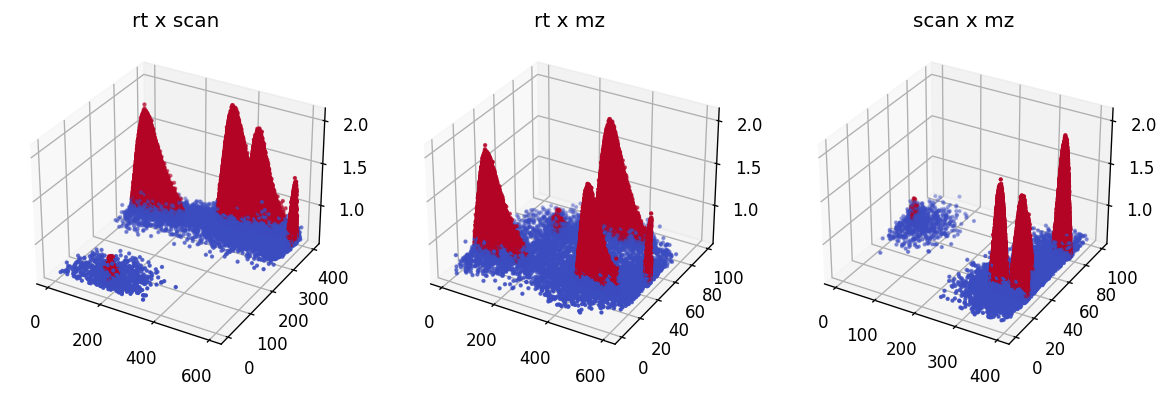

In [88]:
%matplotlib inline
spoints, slabels, sgrid = gen_synth(5)
print(spoints.shape)
print(slabels.shape)
print(sgrid.shape, sgrid.size)

if spoints.shape[0] < 200000:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, subplot_kw={"projection": "3d"}, figsize=(12,8), dpi=120)

    X, Y, Z, W = spoints[:,0], spoints[:,1], spoints[:,2], np.sqrt(spoints[:,3])
    ax1.scatter(X, Y, W, marker=".", s=10, c=slabels, cmap=cm.coolwarm, antialiased=True)
    ax1.set_title("rt x scan")
    ax2.scatter(X, Z, W, marker=".", s=10, c=slabels, cmap=cm.coolwarm, antialiased=True)
    ax2.set_title("rt x mz")
    ax3.scatter(Y, Z, W, marker=".", s=10, c=slabels, cmap=cm.coolwarm, antialiased=True)
    ax3.set_title("scan x mz")


    plt.show()
else:
    print("THERE ARE TOO MANY OF THEM")

# Neural Network

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

In [93]:
#=============#
# ISOGROUPING #
#=============#

# Frame characterization
class Framer(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        filters = [8, 16]
        kernel_sizes = [(3, 2), (3, 1)]
        self.convseq = []
        for (fs, ks) in zip(filters, kernel_sizes):
            self.convseq.append(layers.Conv2D(fs, ks, activation="relu"))
            # Default pool size = (2,2)
            self.convseq.append(layers.MaxPool2D(padding="same"))
            
    def __call__(self, x):
        # TODO: ???
        peak_area = tf.reduce_sum(x, axis=(1,2))
        print("SUM", peak_area.shape)
        for l in self.convseq:
            x = l(x)
            print(x.shape)

        #x = tf.keras.layers.Flatten()(x)
        print(x.shape)
    
        return x

class IsoGrouping(tf.keras.Model):
    def __init__(self, num_frames=5, name=None):
        super().__init__(name=name)
        self.framer = Framer(point_dim)
        self.num_frames = num_frames

    def call(self, x, training=False):
        frame_res = []
        for i in range(self.num_frames):
            frame_res.append(self.framer(x[i]))
        x = tf.concat(frame_res, axis=1)
        if training:
            print("train")
        return x

In [17]:
input_shape_frames = (BATCH_SIZE, 15, 3, 1)

xf_in = tf.keras.Input(shape=input_shape_frames[1:])
z = Framer()(xf_in)

SUM (None, 1)
(None, 13, 2, 8)
(None, 7, 1, 8)
(None, 5, 1, 16)
(None, 3, 1, 16)
(None, 3, 1, 16)


# Old ProteoLizard

In [13]:
print(len(slic.get_precursor_frames()))

slic_filt = slic.filter_ranged(scan_min=0, scan_max=500, mz_min=600, mz_max=601)
scan2iim = dict()

for frame in slic.get_precursor_frames():
    
    temp = dict(zip(np.round(frame.invers_ion_mobility(), 6), frame.scan()))
    scan2iim = {**scan2iim, **temp}
    

scan2iim = list(scan2iim.items())

prec_ids = [p.frame_id() for p in slic_filt.get_precursor_frames()]

fid2rt = list(zip(cursor.meta_data.Id, cursor.meta_data.Time))
idx2rt = dict()
for i,fid in enumerate(prec_ids):
    idx2rt[i] = fid2rt[fid][1]
    
idx2rt = list(idx2rt.items())
#print(idx2rt)

1


In [19]:
import sqlite3 as sql
import pandas as pd
from matplotlib import pyplot as plt

#coords = slic_filt.get_precursor_coords3D_vectorized(2)
points = slic_filt.get_precursor_points()
print(points)
min_scan = np.min(points["scan"])

precursor_tensor = coords.get_zero_indexed_tensor()
#print(precursor_tensor.shape)
t = tf.sparse.reduce_sum(precursor_tensor, axis=[2]).numpy()

peak_data = pd.read_sql_query("SELECT * from LcTimsMsFeature", sql.connect("../../datasets/4DFF/G211202_005_Slot1-1_1_3343___full_clusters_4DFF_v4.features"))

centroids = peak_data.query("MZ >= 600 and MZ <= 601").query("RT >= 24*60 and RT <= 26*60")[["RT","Mobility","MZ","Intensity"]]
centroids["RT"] = centroids["RT"].apply(lambda x: idx2rt[min(range(len(idx2rt)), key = lambda i: abs(idx2rt[i][1]-x))][0])#.apply(lambda x: prec_ids.index(x))#.sub(24*60).div(1.2)
centroids["Mobility"] = centroids["Mobility"].apply(lambda x: scan2iim[min(range(len(scan2iim)), key = lambda i: abs(scan2iim[i][0]-x))][1] - min_scan)
#centroids["Intensity"] = np.sqrt(centroids["Intensity"])

print(centroids)

plt.figure(figsize=(12, 12), dpi=300)
plt.imshow(np.sqrt(t), cmap='hot')

ax = plt.gca()
ax.scatter(centroids["Mobility"], centroids["RT"])
    
plt.show()


    frame  scan  invIonMob          mz  intensity
0     442   188   1.199512  600.381084        120
1     442   195   1.185293  600.346234         58
2     442   200   1.175107  600.338489        158
3     442   201   1.173067  600.195226        122
4     442   205   1.164897  600.098435         46
5     442   206   1.162852  600.261047        134
6     442   210   1.154662  600.241688        160
7     442   215   1.144403  600.346234         20
8     442   217   1.140292  600.206841        140
9     442   217   1.140292  600.272663        106
10    442   218   1.138235  600.110050         52
11    442   222   1.129997  600.311384         44
12    442   223   1.127935  600.334617        100
13    442   223   1.127935  600.350106        142
14    442   224   1.125872  600.326873        142
15    442   225   1.123808  600.144894         86
16    442   225   1.123808  600.253303         20
17    442   230   1.113474  600.338489        194
18    442   231   1.111404  600.551480         48


NameError: name 'coords' is not defined

In [5]:
import sqlite3 as sql
import pandas as pd
pd.read_sql_query("SELECT * from LcTimsMsFeature", sql.connect("../../datasets/4DFF/G211202_005_Slot1-1_1_3343___full_clusters_4DFF_v4.features"))

,Id,FeatureId,AnalysisId,MZ,MZ_lower,MZ_upper,RT,RT_lower,RT_upper,Mobility,Mobility_lower,Mobility_upper,Charge,Intensity,ClusterCount
0,1,0,1,270.185644,270.168269,272.216479,2685.625977,2674.450684,2703.857666,0.833898,0.611613,0.916560,1,2.133579e+06,3
1,2,1,1,288.197461,288.158454,291.251837,2662.100586,2616.803467,2689.741699,0.833898,0.604645,1.017201,1,1.596803e+06,4
2,3,2,1,290.212511,290.195545,293.381011,2713.855225,2675.627441,2729.739990,0.838246,0.606969,0.978934,1,1.399331e+06,4
3,4,3,1,472.771335,472.752275,475.846440,1424.507324,1408.623901,1499.207397,0.842595,0.637070,0.946783,2,1.251140e+06,7
4,5,4,1,477.307331,477.288554,478.850413,1626.849365,1615.674683,1714.499878,0.894782,0.775668,1.000236,2,1.243610e+06,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26960,26961,26960,1,622.928644,622.897038,624.065105,1753.906250,1705.084961,1792.139038,0.919846,0.723915,1.076060,3,8.155308e+02,4
26961,26962,26961,1,640.940612,640.880880,641.981584,1398.624146,1243.925293,1466.267334,0.855642,0.604645,1.115543,3,8.002422e+02,4
26962,26963,26962,1,624.208899,624.104548,625.226319,859.825684,767.472473,895.706482,0.838246,0.616252,1.231832,3,7.978734e+02,4
26963,26964,26963,1,777.245291,777.036552,779.465818,596.273132,501.571198,738.050903,1.037434,0.609291,1.203565,2,6.709961e+02,4


       RT  Mobility          MZ      Intensity
597     4     257.0  600.355838  118018.656250
4281   88     254.0  600.775879   26799.970703
10067   2     274.0  600.282619   10638.969727
34381
656
[[  7.36444349 257.023789  ]
 [ 86.05072464 256.78985507]
 [ 45.42105263 140.63157895]
 [  4.00134366 267.58534458]
 [ 24.26112395 268.64639777]]
[[ 11.38223651  25.08539226]
 [ 37.91771787  36.74569518]
 [243.19113673  29.70637219]
 [  2.87543242  34.84845669]
 [  6.99901111  46.5752466 ]]


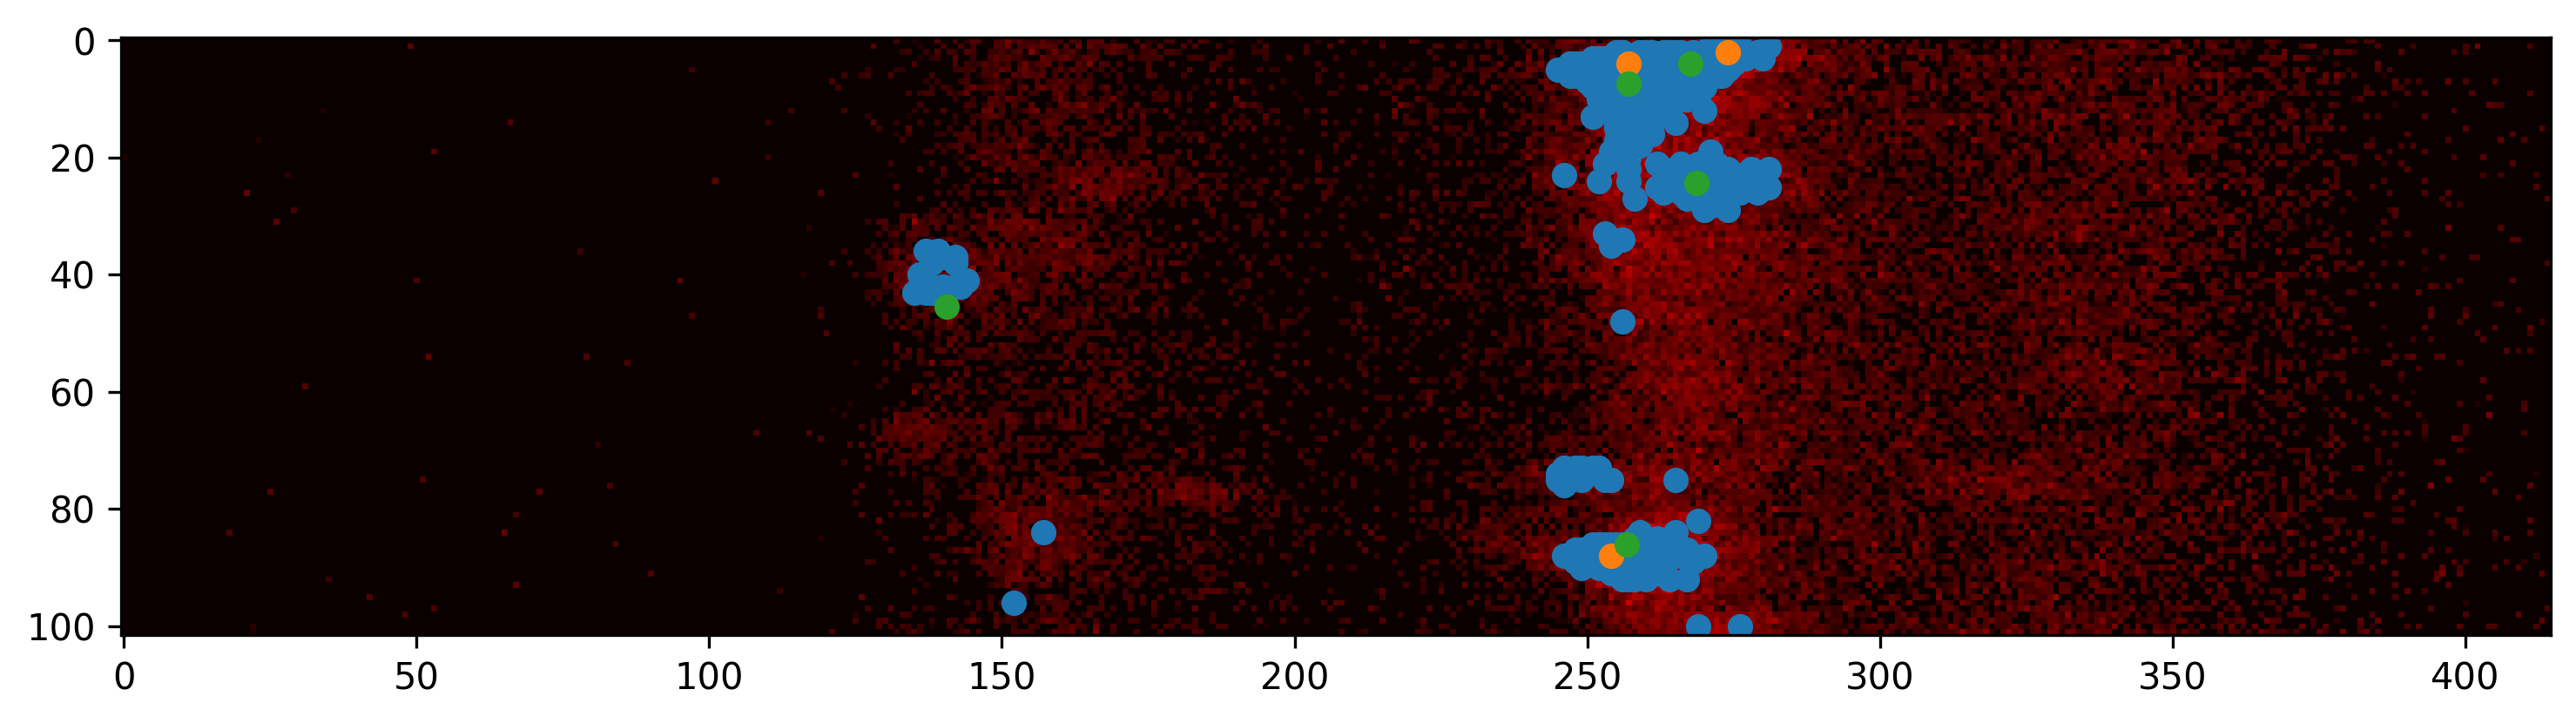

In [20]:
%reset_selective -f gmm
from sklearn.mixture import GaussianMixture
#from sklearn.base import clone

print(centroids)

points_filt = points[points[:,3] > 500][:,:2]
points_filt[:,1] -= min_scan 
print(len(points))
print(len(points_filt))

#gmm = GaussianMixture(n_components=len(centroids[["RT","Mobility"]]), covariance_type="diag", means_init=centroids[["RT","Mobility"]])#, weights_init=points[:,3])
gmm = GaussianMixture(n_components=5, covariance_type="diag")

gmm.fit(points_filt)
print(gmm.means_)

plt.figure(figsize=(12, 12), dpi=300)
plt.imshow(np.sqrt(t), cmap='hot')
print(gmm.covariances_)
ax = plt.gca()
ax.scatter(points_filt[:,1], points_filt[:,0])
ax.scatter(centroids["Mobility"], centroids["RT"])
ax.scatter(gmm.means_[:,1], gmm.means_[:,0])
    
plt.show()

## ProteoLizard/PyTims Data View

In [2]:
import pandas as pd
import numpy as np
import os

from pyproteolizard.data import PyTimsDataHandle
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

dp = "../../datasets/M210115_001_Slot1-1_1_850.d"
bp = "../../proteolizard/python/proteo/lib/python3.8/site-packages/opentims_bruker_bridge/libtimsdata.so"
print(os.getcwd())
print("DATA PATH:", os.path.exists(dp))
print("BRIDGE PATH:", os.path.exists(bp))

dh = PyTimsDataHandle(dp, bp)
dh.meta_data

/mnt/c/Uni/kbetz-msc/python
DATA PATH: True
BRIDGE PATH: True


,Id,Time,Polarity,ScanMode,MsMsType,TimsId,MaxIntensity,SummedIntensities,NumScans,NumPeaks,MzCalibration,T1,T2,TimsCalibration,PropertyGroup,AccumulationTime,RampTime
0,1,0.554466,+,8,0,0,2312,12276207,918,211960,1,25.679766,25.350276,1,1,99.953,99.953
1,2,0.807918,+,8,8,520192,646,51427,918,715,1,25.679790,25.350054,1,1,99.953,99.953
2,3,0.912566,+,8,8,524288,574,61312,918,830,1,25.679790,25.350054,1,1,99.953,99.953
3,4,1.019460,+,8,8,528384,718,44871,918,586,1,25.679790,25.350054,1,1,99.953,99.953
4,5,1.125188,+,8,8,532480,466,53746,918,693,1,25.679790,25.350054,1,1,99.953,99.953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66068,66069,7201.020144,+,8,0,3060596736,803,323681,918,5524,1,25.682739,25.261238,1,1,99.953,99.953
66069,66070,7201.176074,+,8,0,3060617216,548,333792,918,5714,1,25.682739,25.261238,1,1,99.953,99.953
66070,66071,7201.331709,+,8,0,3060641792,560,323692,918,5487,1,25.682739,25.261238,1,1,99.953,99.953
66071,66072,7201.487699,+,8,0,3060662272,435,339513,918,5796,1,25.682739,25.261238,1,1,99.953,99.953


In [33]:
from functools import reduce

def sum_frames(frames):
    subrange_frames = [dh.get_frame(i).vectorized(1) for i in frames]
    return reduce(lambda a,b: a + b, subrange_frames)

def frame_to_points(frame):
    return np.vstack([frame.scans(),
                      frame.indices(),
                      frame.values()]).T

8805


2022-01-26 02:11:58.146194: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1000, 18000)


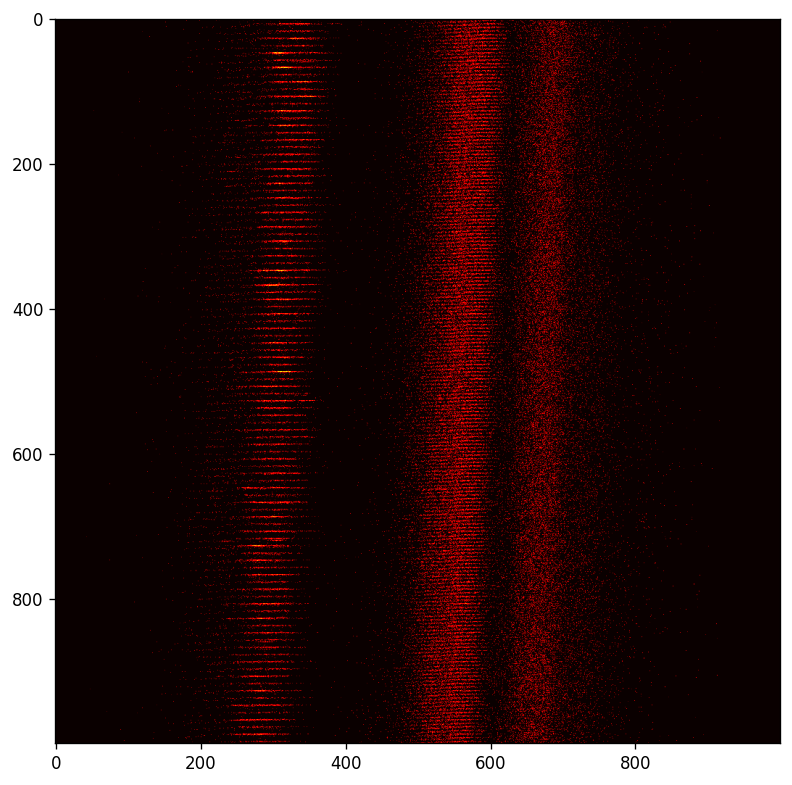

In [28]:
print(len(dh.precursor_frames))

res = sum_frames(dh.precursor_frames[:10])

st = tf.sparse.SparseTensor(indices=np.vstack([res.scans(), res.indices()]).T, values=res.values(), dense_shape=(1000, int(1.8e4)))
print(st.shape)
dt = tf.sparse.to_dense(st)

plt.figure(figsize=(12, 8), dpi=120)
plt.imshow(np.sqrt(dt)[:,10000:11000].T, cmap='hot')
plt.show()



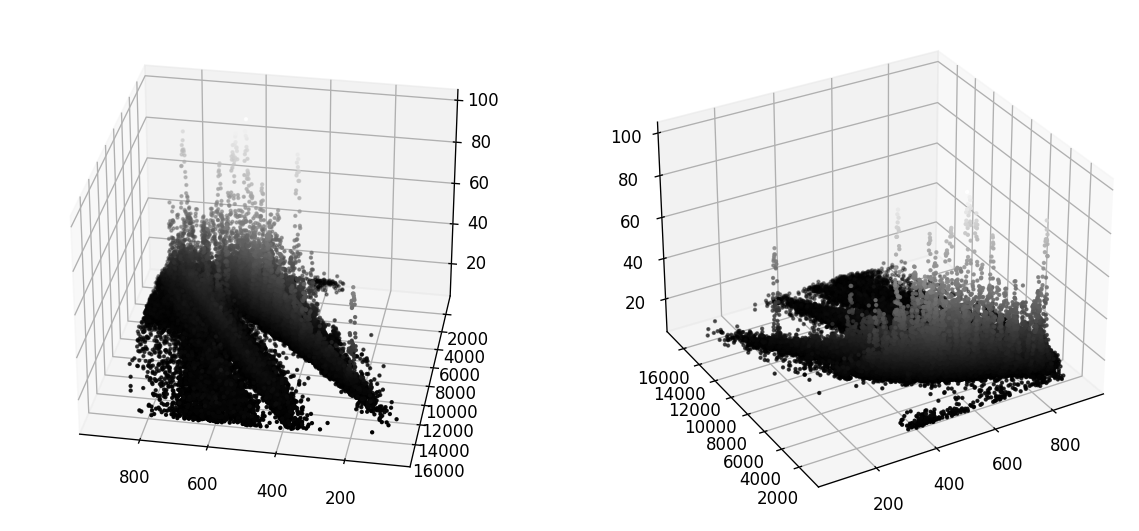

In [5]:
# 3D 
%matplotlib inline
from matplotlib import cm

frame_accum = sum_frames(dh.precursor_frames[:4])

ints = frame_accum.values()
ints_scaled = np.sqrt(ints)

t = 10
mask = ints_scaled > t#np.logical_and(ints_scaled < t, ints_scaled > (t-1))

X = frame_accum.scans()[mask]
Y = frame_accum.indices()[mask]
Z = ints_scaled[mask]

fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={"projection": "3d"}, figsize=(12,8), dpi=120)
#, "zlim":(0,10)

#fig.canvas.toolbar_visible = False
#fig.canvas.header_visible = False
#fig.canvas.resizable = True

ax1.scatter(X, Y, Z, marker=".", s=10, c=Z, cmap=cm.gray, antialiased=True)
ax2.scatter(X, Y, Z, marker=".", s=10, c=Z, cmap=cm.gray, antialiased=True)

ax1.view_init(30,100)
ax2.view_init(30,240)
#ax1.set_zlim(0)
#plt.show()


# Datasets

In [4]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 122s 0us/step


In [13]:
import trimesh
import glob
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))

def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [15]:
data = parse_dataset()

processing class: bed
processing class: monitor
processing class: night_stand
processing class: dresser
processing class: desk
processing class: bathtub
processing class: toilet
processing class: chair
processing class: table
processing class: sofa
